In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

In [3]:
df=pd.read_csv('NFLX.csv')

In [4]:
open_price=df['Open']
print(open_price)

0       262.000000
1       247.699997
2       266.579987
3       267.079987
4       253.850006
           ...    
1004    401.970001
1005    432.959991
1006    448.250000
1007    421.440002
1008    407.309998
Name: Open, Length: 1009, dtype: float64


In [5]:
seq_len=15

In [6]:
mm=MinMaxScaler()

In [7]:
scaled_price=mm.fit_transform(np.array(open_price)[...,None]).squeeze()
print(scaled_price)

[0.06125254 0.03005911 0.07124314 ... 0.46753051 0.4090483  0.3782257 ]


In [8]:
X=[]
Y=[]
for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    Y.append(scaled_price[i + seq_len])

In [9]:
print(X[0])

[0.06125254 0.03005911 0.07124314 0.07233381 0.04347449 0.03974435
 0.05097837 0.05791507 0.07876885 0.09774669 0.0955871  0.10503242
 0.10898067 0.10269835 0.11960388]


In [10]:
X=np.array(X)[...,None]
Y=np.array(Y)[...,None]

In [11]:
train_X=torch.from_numpy(X[ : int(0.8 * X.shape[0])]).float()
train_Y=torch.from_numpy(Y[ : int(0.8 * Y.shape[0])]).float()
test_X=torch.from_numpy(X[int(0.8 * X.shape[0]) : ]).float()
test_Y=torch.from_numpy(Y[int(0.8 * X.shape[0]) : ]).float()

In [12]:
print(train_X.shape,train_Y.shape)

torch.Size([795, 15, 1]) torch.Size([795, 1])


In [13]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size,1)
    def forward(self,x):
        output , (hidden , cell)= self.lstm(x)
        return self.fc(output[: , -1 , :])
        
model = Model(1 , 96)

In [14]:
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [15]:
num_epochs = 100

In [16]:
for epoch in range(num_epochs):
    output = model(train_X)
    loss = loss_fn(output , train_Y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())
        

10 epoch loss 0.041489463
20 epoch loss 0.02367309
30 epoch loss 0.022595685
40 epoch loss 0.016748378
50 epoch loss 0.009932409
60 epoch loss 0.0026574803
70 epoch loss 0.0029841105
80 epoch loss 0.0021254378
90 epoch loss 0.002096927


In [17]:
model.eval()
with torch.no_grad():
    output = model(test_X)

In [18]:
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_Y.numpy())

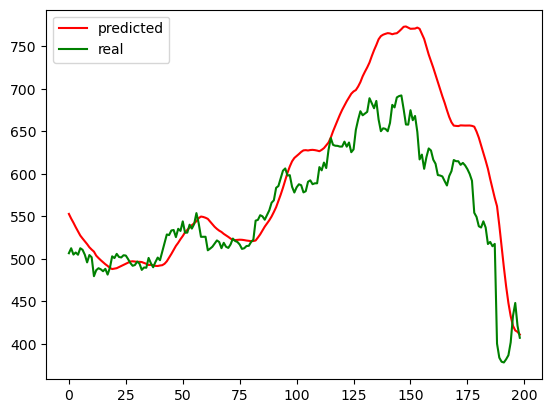

In [20]:
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.legend(loc='best')
plt.show()